# 1

Epoch 1/50


C:\Users\janak\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1648 - val_loss: 0.0291
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0280 - val_loss: 0.0248
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0238 - val_loss: 0.0224
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0206 - val_loss: 0.0206
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192 - val_loss: 0.0193
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 - val_loss: 0.0184
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0182 - val_loss: 0.0180
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - val_loss: 0.0178
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - val_loss: 0.0178
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0173 - val_loss: 0.0178
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0174 - val_loss: 0.0176
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169 - val_loss: 0.0175


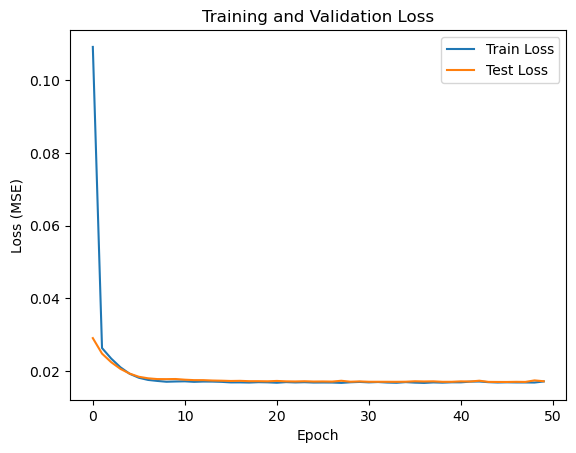

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R^2 Score: 0.3142
MAE: 5.286047554604207e-05
Test MSE: 4.825886564000792e-09


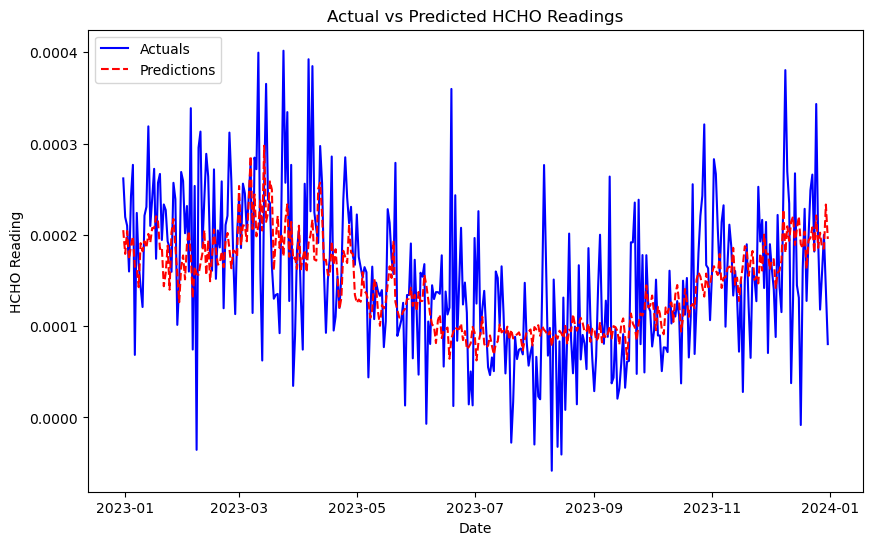

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Load the dataset
df = pd.read_csv(r"..\processed data\all_data_combined.csv")
df = df[df['Location'] == 'Colombo Proper']

# Define columns to keep
columns_to_keep = ['Current_Date', 'HCHO_reading', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'Population', 
                   'Population_density', 'total', 'new', 'Lockdown', 'carbonmonoxide_average', 
                   'nitrogendioxide_average', 'ozone_average']

df = df[columns_to_keep]

# Convert 'Current_Date' to DateTime format
df['Current_Date'] = pd.to_datetime(df['Current_Date'])

# Sort by date and set index
df = df.sort_values(by='Current_Date')
df.set_index('Current_Date', inplace=True)

# Define input features (X) and target variable (y)
X_cols = ['TMAX', 'TMIN','carbonmonoxide_average', 'nitrogendioxide_average', 'ozone_average']
y_col = ['HCHO_reading']

X = df[X_cols]  # Features
y = df[y_col]   # Target

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape input data to 3D array (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model and capture history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

# Plot loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Predictions on test data
y_pred = model.predict(X_test)

# Rescale predictions and actuals
y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test.reshape(X_test.shape[0], -1)[:, :-1], y_pred), axis=1))
y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test.reshape(X_test.shape[0], -1)[:, :-1], y_test.reshape(-1, 1)), axis=1))

# Extract the HCHO readings
y_pred_hcho = y_pred_rescaled[:, -1]
y_test_hcho = y_test_rescaled[:, -1]

# Calculate R^2 score and MAE
r2 = round(r2_score(y_test_hcho, y_pred_hcho), 4)
mae = mean_absolute_error(y_test_hcho, y_pred_hcho)
mse = mean_squared_error(y_test_hcho, y_pred_hcho)
print("R^2 Score:", r2)
print("MAE:", mae)
print("Test MSE:", mse)

# Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.plot(df.index[-len(y_test_hcho):], y_test_hcho, label='Actuals', color='blue')
plt.plot(df.index[-len(y_pred_hcho):], y_pred_hcho, label='Predictions', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('Actual vs Predicted HCHO Readings')
plt.legend()
plt.show()


# 2

Epoch 1/50


C:\Users\janak\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1548 - val_loss: 0.0239
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - val_loss: 0.0235
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0225 - val_loss: 0.0235
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0223 - val_loss: 0.0230
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214 - val_loss: 0.0229
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0220 - val_loss: 0.0221
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0211 - val_loss: 0.0217
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0206 - val_loss: 0.0208
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198 - val_loss: 0.0197
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 - val_loss: 0.0192
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190 - val_loss: 0.0183
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168 - val_loss: 0.0184


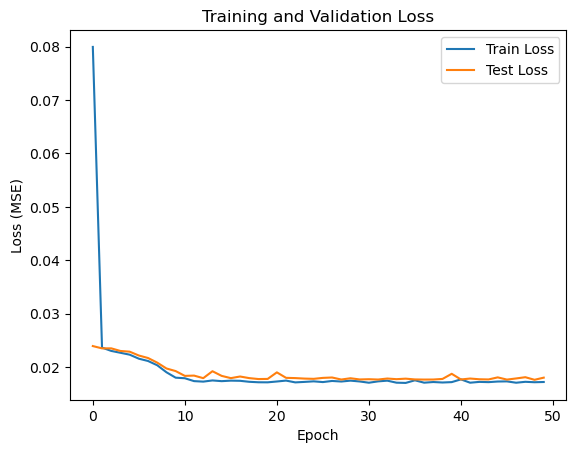

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R^2 Score: 0.2879
MAE: 5.469974851100824e-05
Test MSE: 5.010928328667828e-09


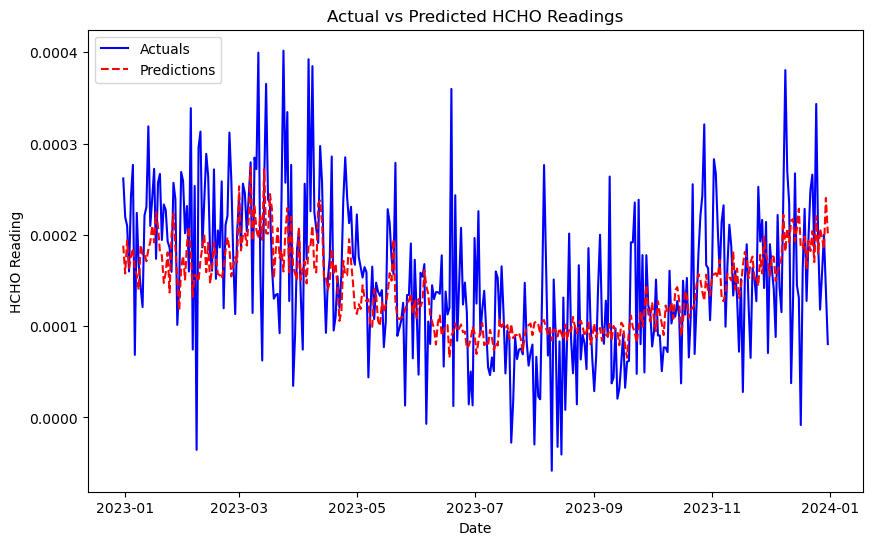

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Load the dataset
df = pd.read_csv(r"..\processed data\all_data_combined.csv")
df = df[df['Location'] == 'Colombo Proper']

# Define columns to keep
columns_to_keep = ['Current_Date', 'HCHO_reading', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'Population', 
                   'Population_density', 'total', 'new', 'Lockdown', 'carbonmonoxide_average', 
                   'nitrogendioxide_average', 'ozone_average']

df = df[columns_to_keep]

# Convert 'Current_Date' to DateTime format
df['Current_Date'] = pd.to_datetime(df['Current_Date'])

# Sort by date and set index
df = df.sort_values(by='Current_Date')
df.set_index('Current_Date', inplace=True)

# Define input features (X) and target variable (y)
X_cols = ['TMAX', 'TMIN','carbonmonoxide_average', 'nitrogendioxide_average', 'ozone_average']
y_col = ['HCHO_reading']

X = df[X_cols].values  # Features
y = df[y_col].values   # Target

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# # Reshape input data to 3D array (samples, timesteps, features)
# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model and capture history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

# Plot loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Predictions on test data
y_pred = model.predict(X_test)

# Rescale predictions and actuals
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Calculate R^2 score and MAE
r2 = round(r2_score(y_test_hcho, y_pred_hcho), 4)
mae = mean_absolute_error(y_test_hcho, y_pred_hcho)
mse = mean_squared_error(y_test_hcho, y_pred_hcho)
print("R^2 Score:", r2)
print("MAE:", mae)
print("Test MSE:", mse)

# Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.plot(df.index[-len(y_test_rescaled):], y_test_rescaled, label='Actuals', color='blue')
plt.plot(df.index[-len(y_pred_rescaled):], y_pred_rescaled, label='Predictions', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('Actual vs Predicted HCHO Readings')
plt.legend()
plt.show()


Epoch 1/50


C:\Users\janak\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1371 - val_loss: 0.0256
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0260 - val_loss: 0.0234
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209 - val_loss: 0.0215
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0203 - val_loss: 0.0200
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0180 - val_loss: 0.0190
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0187 - val_loss: 0.0184
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171 - val_loss: 0.0180
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0176 - val_loss: 0.0179
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165 - val_loss: 0.0178
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 - val_loss: 0.0176
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183 - val_loss: 0.0176
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - val_loss: 0.0176


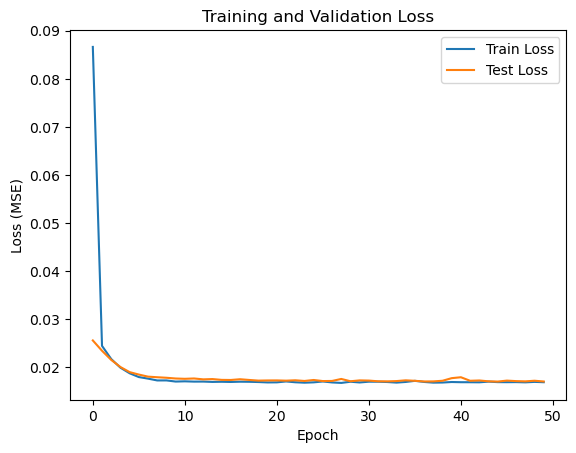

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
R^2 Score: 0.3225
MAE: 5.271240552345154e-05
Test MSE: 4.767662364026277e-09


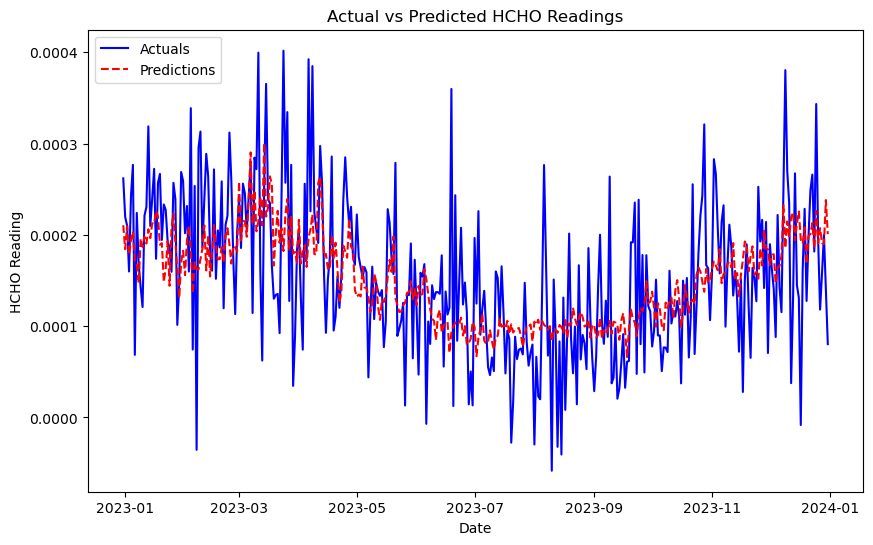

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Load the dataset
df = pd.read_csv(r"..\processed data\all_data_combined.csv")
df = df[df['Location'] == 'Colombo Proper']

# Define columns to keep
columns_to_keep = ['Current_Date', 'HCHO_reading', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'Population', 
                   'Population_density', 'total', 'new', 'Lockdown', 'carbonmonoxide_average', 
                   'nitrogendioxide_average', 'ozone_average']

df = df[columns_to_keep]

# Convert 'Current_Date' to DateTime format
df['Current_Date'] = pd.to_datetime(df['Current_Date'])

# Sort by date and set index
df = df.sort_values(by='Current_Date')
df.set_index('Current_Date', inplace=True)

# Define input features (X) and target variable (y)
X_cols = ['TMAX', 'TMIN','carbonmonoxide_average', 'nitrogendioxide_average', 'ozone_average']
y_col = ['HCHO_reading']

X = df[X_cols].values  # Features
y = df[y_col].values   # Target

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape input data to 3D array (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model and capture history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

# Plot loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Predictions on test data
y_pred = model.predict(X_test)

# Rescale predictions and actuals
y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test.reshape(X_test.shape[0], -1)[:, :-1], y_pred), axis=1))
y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test.reshape(X_test.shape[0], -1)[:, :-1], y_test.reshape(-1, 1)), axis=1))

# Extract the HCHO readings
y_pred_hcho = y_pred_rescaled[:, -1]
y_test_hcho = y_test_rescaled[:, -1]

# Calculate R^2 score and MAE
r2 = round(r2_score(y_test_hcho, y_pred_hcho), 4)
mae = mean_absolute_error(y_test_hcho, y_pred_hcho)
mse = mean_squared_error(y_test_hcho, y_pred_hcho)
print("R^2 Score:", r2)
print("MAE:", mae)
print("Test MSE:", mse)

# Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.plot(df.index[-len(y_test_hcho):], y_test_hcho, label='Actuals', color='blue')
plt.plot(df.index[-len(y_pred_hcho):], y_pred_hcho, label='Predictions', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('Actual vs Predicted HCHO Readings')
plt.legend()
plt.show()
